In [1]:
import math
import itertools
from collections.abc import Iterable, Collection
from numbers import Number
from typing import Tuple, List, Union

import yaml

import numpy as np

%matplotlib widget
import matplotlib
import matplotlib.axes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
import gtsam

In [3]:
from dataclasses import dataclass
from typing import Dict, Set, List

@dataclass
class UnionFindNode:
    """ Class for keeping Union Find Node data"""
    value: int # Value of node
    parent: int # Parent node value
    rank: int # Higher bound on height

class UnionFind:
    def __init__(self):
        
        self.nodes : Dict[int, UnionFindNode] = {}
        self.roots : Set[int] = set()
        
    def make_set(self, x: int) -> None:
        if x not in self.nodes:
            self.nodes[x] = UnionFindNode(x, x, 0)
            self.roots.add(x)
        
    def find(self, x: int) -> int:
        """ Return root of set x belongs to. None if x does not exist in any set 
        
        Parameter
        ---------
        x: int
            id of node to get root of

        Return
        -------
        root: int
            id of root of set containing node id x
        
        """
        # Check if x exist in any set
        if x not in self.nodes:
            raise ValueError(f'Key {x} not found')
        
        # Search for root and path compression
        cur_node = self.nodes[x]
        while cur_node.parent != cur_node.value:
            parent_node = self.nodes[cur_node.parent]
            cur_node.parent = self.nodes[parent_node.parent].value # update to grand parent
            cur_node = parent_node
            
        return cur_node.value
        
    def union(self, x: int, y: int) -> None:
        a = self.nodes[self.find(x)]
        b = self.nodes[self.find(y)]
        
        if a.value != b.value:
            # Union if x and y is not part of same set
            if a.rank < b.rank:
                a,b = b,a # Swap to make a at least as large as b
                x,y = y,x

            b.parent = a.value # Re-parent
            
            # b is not root anymore
            # print(f'[Union {x},{y}] {a.value=} {b.value=} Set before: {self.roots}')
            self.roots.remove(b.value)
            # self.roots.remove(y)
            # print(f'[Union {x},{y}] {a.value=} {b.value=} Set After: {self.roots}')

            if a.rank == b.rank:
                a.rank += 1 # Re calculate rank
        
    def get_roots(self) -> Set[int]:
        return self.roots
    

In [4]:
def cluster_scan(scan_r, scan_theta, scan_points,
                max_neighbour_distance = 0.03, min_points = 5):
    """USE NP.TAKE mode wrap to query"""

    # Sort point by angle
    scan_sorted_index = np.argsort(scan_theta)

    # scan_r_sorted = scan_r[scan_sorted_index]
    # scan_theta_sorted = scan_theta[scan_sorted_index]

    scan_points_sorted = scan_points[scan_sorted_index]

    scan_points_diff = np.roll(scan_points_sorted, -1, axis=0) - scan_points_sorted

    scan_points_diff_distance = np.sqrt(np.sum(np.power(scan_points_diff, 2), axis=-1))

    cluster_member_mask = scan_points_diff_distance <= max_neighbour_distance
    bound_mask = np.diff(cluster_member_mask.astype(int), axis=0, prepend=0)
    bound_start_mask = bound_mask > 0
    bound_end_mask = bound_mask < 0

    derivative_count = 1

    cluster_start = np.where(bound_start_mask)[0]
    cluster_end = np.where(bound_end_mask)[0] + derivative_count

    if len(cluster_start) != len(cluster_end):
        cluster_end = np.concatenate([cluster_end, [len(cluster_member_mask)]], axis=0)

    # Loop back
    cluster_bound_pair = np.stack([
        cluster_start, 
        cluster_end, 
    ], axis=-1)

    if len(cluster_bound_pair) > 1:
        if cluster_member_mask[-1] and cluster_member_mask[0]:
            # Fuse first and last cluster
            cluster_bound_pair[0,0] = cluster_bound_pair[-1,0] - len(cluster_member_mask)
            cluster_bound_pair = cluster_bound_pair[:-1,:]

    cluster_size = np.diff(cluster_bound_pair, axis=-1)[..., 0]

    valid_cluster_mask = cluster_size > min_points

    filtered_cluster_bound_pair = cluster_bound_pair[valid_cluster_mask]

    return scan_sorted_index, filtered_cluster_bound_pair

def points_to_distance_angle(points):

    r = np.sqrt(np.sum(np.power(points,2), axis=-1))
    theta = np.arctan2(points[:, 1], points[:, 0])

    return r, theta

def fit_line(points: np.ndarray) -> np.ndarray:
    """Fit line to points. Require Length at least 2 distint points.
    
    Parameters
    ---------
    points: float np.ndarray[N,2]
        points to fit the line. Require at least 2 distinct points

    Returns
    --------
    slope_intercept: float np.ndarray[2, ]
        where slope_intercept = [a b] where y = ax + b

    Raise
    -------
    ValueError
        Not enough distinct points (<2) or singular A.T @ A
    
    """
    EPSILON = 1e-5

    n = len(points)
    if n < 2:
        raise ValueError(f'Required at least 2 points. Received {n} points. {points}')

    A = np.stack([points[:, 0], np.ones((n,))], axis=-1)

    ata = A.T @ A

    det = np.linalg.det(ata)
    if np.abs(det) < EPSILON:
        raise ValueError(f'Singular. Received {n} points. {points}')
    
    ata_inverse = np.linalg.inv(ata)

    # slope_intercept = [a b].T where y=ax+b
    slope_intercept = ata_inverse @ A.T @ np.expand_dims(points[:, 1], -1)

    return np.squeeze(slope_intercept)

def fit_line_uniform(points: np.ndarray, max_variance_threshold: float) -> np.ndarray:
    """Fit line to points. Require Length at least 2 distint points.
    
    Parameters
    ---------
    points: float np.ndarray[N,2]
        points to fit the line. Require at least 2 distinct points

    max_variance_threshold: float
        max variance accepted for point uniformity on the line. Threshold for varianceo of difference between consecutive points projected on the line

    Returns
    --------
    slope_intercept: float np.ndarray[2, ]
        where slope_intercept = [a b] where y = ax + b

    Raise
    -------
    ValueError
        Not enough distinct points (<2) or singular A.T @ A
    
    """
    EPSILON = 1e-5

    n = len(points)
    if n < 2:
        raise ValueError(f'Required at least 2 points. Received {n} points. {points}')

    A = np.stack([points[:, 0], np.ones((n,))], axis=-1)

    ata = A.T @ A

    det = np.linalg.det(ata)
    if np.abs(det) < EPSILON:
        raise ValueError(f'Singular. Received {n} points. {points}')
    
    ata_inverse = np.linalg.inv(ata)

    # slope_intercept = [a b].T where y=ax+b
    slope_intercept = ata_inverse @ A.T @ np.expand_dims(points[:, 1], -1)

    slope_intercept = np.squeeze(slope_intercept)

    parallel_distance, _ = get_point_line_parallel_perpendicular(points, *slope_intercept_to_vector_form(slope_intercept))

    parallel_distance_sorted = np.sort(parallel_distance)
    parallel_distance_sorted_diff = np.diff(parallel_distance_sorted)
    parallel_distance_sorted_diff_var = np.var(parallel_distance_sorted_diff)

    if np.any(parallel_distance_sorted_diff_var > max_variance_threshold):
        raise ValueError(f'Line not uniform enough. Max Variance: {np.max(parallel_distance_sorted_diff_var)}. Threshold: {max_variance_threshold}')

    return np.squeeze(slope_intercept)

def fit_line_ransac(points: np.ndarray,
                    fit_line_max_variance_threshold: float,
                    min_inlier_points: int,
                    sample_size: int,
                    inlier_distance_threshold: float,
                    inlier_proability: float,
                    success_probability: float = 0.95,
                    max_iterations: int = 10000
                    ) -> np.ndarray:

    iterations = int(math.ceil(math.log(1.0 - success_probability) / math.log(1.0 - inlier_proability ** sample_size)))
    iterations = min(max_iterations, iterations)

    data_n = len(points)

    best_inlier_count = min_inlier_points
    best_line_fit = None

    for i in range(iterations):

        # Sample random subset
        sample_index = np.random.choice(data_n, size=sample_size)
        sample_points = points[sample_index]

        # Fit line
        try:
            # line_slope_intercept = fit_line_uniform(sample_points, fit_line_max_variance_treshold)
            line_slope_intercept = fit_line(sample_points)
        except ValueError:
            # Error in line selection
            continue

        line_p, line_v_hat = slope_intercept_to_vector_form(line_slope_intercept)

        # Evaluate inliers
        parallel_distance, perpendicular_distance = get_point_line_parallel_perpendicular(points, line_p, line_v_hat)

        inlier_mask = perpendicular_distance < inlier_distance_threshold
        inlier_points = points[inlier_mask]

        inlier_count = np.sum(inlier_mask.astype(int))

        if inlier_count < best_inlier_count:
            continue

        inlier_parallel_distance = parallel_distance[inlier_mask]

        parallel_distance_sort_index = np.argsort(inlier_parallel_distance)
        parallel_distance_sorted = inlier_parallel_distance[parallel_distance_sort_index]

        parallel_distance_sorted_diff = np.diff(parallel_distance_sorted)
        parallel_distance_sorted_diff_var = np.var(parallel_distance_sorted_diff)

        if np.any(parallel_distance_sorted_diff_var > fit_line_max_variance_threshold):
            # Discard line, not uniform enough
            print(f'Not uniform enough. {np.max(parallel_distance_sorted_diff_var)} - {fit_line_max_variance_threshold}')
            continue

        if inlier_count >= best_inlier_count:
            # Refit line
            best_line_fit = fit_line(inlier_points)
            best_inlier_count = inlier_count

    # Return best
    return best_line_fit




def slope_intercept_to_vector_form(slope_intercept: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Convert line slope intercept form to vector form
    
    Parameters
    ----------
    slope_intercept: float np.ndarray[2, ]
        [slope, intercept]

    Returns
    -------
        p: float np.ndarray[1, 2]
            position vector of point on line, orthogonal to direction
        v_hat: float np.ndarray[1, 2]
            normalized direction vector of line
    """

    # y = ax + b

    slope, intercept = slope_intercept

    v = np.array([[1.0, slope]])
    v_hat = v / np.expand_dims(np.linalg.norm(v), axis=-1)

    x = 0.0
    y = slope * x + intercept
    point_on_line = np.array([[x, y]])
    
    perpendicular_point = point_on_line - (np.sum(np.multiply(v_hat, point_on_line)))*v_hat

    return perpendicular_point, v_hat

def line_vector_form_from_line_segment(x_0: np.ndarray, x_1: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Return line in vectorm form
    
    Parameters
    ----------
    x_0: float np.ndarray[1,2]
    x_1: float np.ndarray[1,2]

    Returns
    -------
    p: float np.ndarray[1,2]
        vector from origin to point on line. Perpedicular to v

    v: float np.ndarray[1,2]
        unit direction vector of line
    
    """

    EPSILON = 1e-6
    if x_0.shape != (1,2) or x_1.shape != (1,2):
        raise ValueError(f'Expected shaped (1,2) but received {x_0.shape=} and {x_1.shape=}')

    v = x_1 - x_0
    v_norm = np.linalg.norm(v)

    if v_norm < EPSILON:
        # Same point
        raise ValueError(f'Two points are the same/. {x_0=} {x_1=}')
    
    v_hat = v / v_norm
    
    perpendicular_point = x_0 - (np.sum(np.multiply(v_hat, x_0)))*v_hat
    
    return perpendicular_point, v_hat

def line_vector_to_hessian_form(p, v_hat):
    """Assuming p is already perpendicular point
    
    Returns
    -------
    line_hessian_form: float np.array[2,]
        Line in hessian normal form. [r, alpha] where r is distance from origin, alpha is angle from x [-pi, pi]
    
    """

    r = np.linalg.norm(p)
    alpha = np.arctan2(p[0,1], p[0,0])

    return np.array([r, alpha])

def get_point_line_parallel_perpendicular(points: np.ndarray, p: np.ndarray, v_hat: np.ndarray) -> np.ndarray:
    """Get point parallel distance from p and (perpendicular) distance from line defined by position p and direction v_hat
    
    Parameters
    -----------
        points: float np.ndarray[N, 2]
            points to contain in line

        p: float np.ndarray[1, 2]
            position vector of point on line, orthogonal to direction

        v_hat: float np.ndarray[1, 2]
            normalized direction vector of line

    Returns
    -----------
        points_parallel_distance: float np.ndarray[N, ]
            Parallel distance of points to p

        points_perpendicular_distance: float np.ndarray[N, ]
            Perpendicular distance of points to line
    
    """

    line_to_points = points - p
    
    points_parallel_distance = np.sum(np.multiply(line_to_points, v_hat), axis=-1)

    line_to_point_project_normal = line_to_points - np.multiply(np.expand_dims(points_parallel_distance, -1), v_hat)

    points_perpendicular_distance = np.linalg.norm(line_to_point_project_normal, axis=-1)

    return points_parallel_distance, points_perpendicular_distance

def split_and_merge_points(scan_points: np.ndarray, inlier_distance_threshold: Number, merge_distance_threshold: Number, min_line_points: int = 10) -> List[np.ndarray]:
    """Split and merge algorithm
    
    1) Fit line to set
    2) 
    
    """

    def split(scan_points: np.ndarray, inlier_distance_threshold: Number) -> List[Tuple[np.ndarray, np.ndarray]]:
        """Split subroutine.
        
        
        Returns
        --------
            lines: List[Tuple[float np.ndarray[2, ], np.ndarray[M, 2]]]
                list of tuple containing (line parameter, line points)

                line parameter: float np.ndarray[2, ]
                    Contains R, perpendicular distance from origin, and alpha, angle of normal of line to x axis

                line points: float np.ndarray[M, 2]
                    Points used to form the line
        
        """
        
        n = len(scan_points)
        if n < min_line_points:
            return []

        try:
            slope_intercept = fit_line(scan_points)
        except ValueError as e:
            # No line can be formed
            return []
        p1, v_hat1 = slope_intercept_to_vector_form(slope_intercept)

        points_parallel_distance_1, points_perpendicular_distance_1 = get_point_line_parallel_perpendicular(scan_points, p1, v_hat1)

        furthest_distance_index = np.argmax(points_perpendicular_distance_1)
        furthest_distance = points_perpendicular_distance_1[furthest_distance_index]

        if furthest_distance < inlier_distance_threshold:
            # Return line
            return [(p1, v_hat1, scan_points)]

        # Sort points
        point_sort_index = np.argsort(points_parallel_distance_1)
        scan_points_sorted = scan_points[point_sort_index]

        # Assume sorted points
        # Points can be sorted by arranging in order of increasing parallel distance
        first_point = np.expand_dims(scan_points_sorted[0], axis=0)
        last_point = np.expand_dims(scan_points_sorted[-1], axis=0)

        p2, v_hat2 = line_vector_form_from_line_segment(first_point, last_point)

        points_parallel_distance_2, points_perpendicular_distance_2 = get_point_line_parallel_perpendicular(scan_points_sorted, p2, v_hat2)

        furthest_distance_2_index = np.argmax(points_perpendicular_distance_2)

        lines = []

        try:
            first_split = split(scan_points_sorted[:furthest_distance_2_index], inlier_distance_threshold)
            lines.extend(first_split)
        except ValueError as e:
            pass
        
        try:
            second_split = split(scan_points_sorted[furthest_distance_2_index:], inlier_distance_threshold)
            lines.extend(second_split)
        except ValueError as e:
            pass

        return lines

    def merge(line_list, merge_distance_threshold: Number, inlier_distance_threshold: Number):
        """
        
        merge_distance_threshold: Number
            threshold to consider 2 line similar

        inlier_distance_threshold: Number
            threshold to consider for line segment forming
        """


        n = len(line_list)

        if n < 2:
            return []
        

        # N x 2
        lines_hessian = np.stack([line_vector_to_hessian_form(p, v_hat) for p,v_hat,_ in line_list], axis=0)

        # Symmetric
        
        line_hessian_difference = np.expand_dims(lines_hessian, axis=1) - np.expand_dims(lines_hessian, axis=0)

        # TODO: Get min angle instead
        angle_difference = line_hessian_difference[..., -1]
        angle_difference_abs = np.abs(angle_difference)
        line_hessian_difference[..., -1] = np.minimum(angle_difference_abs, 2*math.pi - angle_difference_abs) # Since will be squared anyways

        line_hessian_difference_2 = np.power(line_hessian_difference, 2)

        similar_line_matrix = np.sum(line_hessian_difference_2,axis=-1) <= merge_distance_threshold


        # Form N sets
        disjoint_sets = UnionFind()
        for i in range(n):
            disjoint_sets.make_set(i)

        for i in range(n):
            for j in range(n):
                if(j >= i):
                    # Skip half triangle
                    break

                # print(f'[{i=},{j=}] {similar_line_matrix[j,i]=}')
                if similar_line_matrix[j,i]:
                    # Combine sets
                    # print(f'[{i=},{j=}] {similar_line_matrix[j,i]=} Pass')
                    disjoint_sets.union(i,j)

        set_roots = disjoint_sets.get_roots()

        lines = []
        for root in set_roots:

            point_set = []
            set_size = 0
            for i in range(n):
                if similar_line_matrix[root][i]:
                    point_set.append(line_list[i][-1])
                    set_size += 1

            point_set = np.concatenate(point_set, axis=0)

            # print(f'{root=} {set_size}')

            p, v_hat = line_list[root][:-1]

            if set_size > 1:
                # Fit line to point set
                line_slope_intercept = fit_line(point_set)
                p, v_hat = slope_intercept_to_vector_form(line_slope_intercept)
            line_segment = line_to_segment(point_set, p, v_hat, inlier_distance_threshold)

            if line_segment is None:
                continue

            lines.append((line_segment, point_set))

        return lines

    line_list = split(scan_points, inlier_distance_threshold)
    
    refined_line_list = merge(line_list, merge_distance_threshold, inlier_distance_threshold)

    return refined_line_list

def split_and_merge_points_ransac(scan_points: np.ndarray, 
                                  inlier_distance_threshold: Number, 
                                  merge_distance_threshold: Number, 
                                  fit_line_max_variance_thresold: Number,
                                  ransac_inlier_distance_threshold: Number,
                                  min_line_points: int = 10,
                                  ransac_inlier_probability: Number = 0.8,
                                  ransac_success_probability: Number = 0.95,
                                  ransac_sample_size: int = 5,
                                  ransac_max_iterations: int = 10000
                                  ) -> List[np.ndarray]:
    """Split and merge algorithm
    
    1) Fit line to set
    2) 
    
    """

    def split(scan_points: np.ndarray, inlier_distance_threshold: Number) -> List[Tuple[np.ndarray, np.ndarray]]:
        """Split subroutine.
        
        
        Returns
        --------
            lines: List[Tuple[float np.ndarray[2, ], np.ndarray[M, 2]]]
                list of tuple containing (line parameter, line points)

                line parameter: float np.ndarray[2, ]
                    Contains R, perpendicular distance from origin, and alpha, angle of normal of line to x axis

                line points: float np.ndarray[M, 2]
                    Points used to form the line
        
        """
        
        n = len(scan_points)
        if n < min_line_points:
            return []

        try:
            # slope_intercept = fit_line(scan_points)
            slope_intercept = fit_line_ransac(scan_points,
                            fit_line_max_variance_threshold=fit_line_max_variance_thresold,
                            min_inlier_points=min_line_points,
                            sample_size=ransac_sample_size,
                            inlier_distance_threshold=ransac_inlier_distance_threshold,
                            inlier_proability=ransac_inlier_probability,
                            success_probability=ransac_success_probability, max_iterations=ransac_max_iterations)
        except ValueError as e:
            # No line can be formed
            return []
        
        if slope_intercept is None:
            # No line found
            
            return []
        p1, v_hat1 = slope_intercept_to_vector_form(slope_intercept)

        points_parallel_distance_1, points_perpendicular_distance_1 = get_point_line_parallel_perpendicular(scan_points, p1, v_hat1)

        furthest_distance_index = np.argmax(points_perpendicular_distance_1)
        furthest_distance = points_perpendicular_distance_1[furthest_distance_index]

        if furthest_distance < inlier_distance_threshold:
            # Return line
            return [(p1, v_hat1, scan_points)]

        # Sort points
        point_sort_index = np.argsort(points_parallel_distance_1)
        scan_points_sorted = scan_points[point_sort_index]

        # Assume sorted points
        # Points can be sorted by arranging in order of increasing parallel distance
        first_point = np.expand_dims(scan_points_sorted[0], axis=0)
        last_point = np.expand_dims(scan_points_sorted[-1], axis=0)

        p2, v_hat2 = line_vector_form_from_line_segment(first_point, last_point)

        points_parallel_distance_2, points_perpendicular_distance_2 = get_point_line_parallel_perpendicular(scan_points_sorted, p2, v_hat2)

        furthest_distance_2_index = np.argmax(points_perpendicular_distance_2)

        lines = []

        try:
            first_split = split(scan_points_sorted[:furthest_distance_2_index], inlier_distance_threshold)
            lines.extend(first_split)
        except ValueError as e:
            pass
        
        try:
            second_split = split(scan_points_sorted[furthest_distance_2_index:], inlier_distance_threshold)
            lines.extend(second_split)
        except ValueError as e:
            pass

        return lines

    def merge(line_list, merge_distance_threshold: Number, inlier_distance_threshold: Number):
        """
        
        merge_distance_threshold: Number
            threshold to consider 2 line similar

        inlier_distance_threshold: Number
            threshold to consider for line segment forming
        """


        n = len(line_list)

        if n < 2:
            return []
        

        # N x 2
        lines_hessian = np.stack([line_vector_to_hessian_form(p, v_hat) for p,v_hat,_ in line_list], axis=0)

        # Symmetric
        
        line_hessian_difference = np.expand_dims(lines_hessian, axis=1) - np.expand_dims(lines_hessian, axis=0)

        # TODO: Get min angle instead
        angle_difference = line_hessian_difference[..., -1]
        angle_difference_abs = np.abs(angle_difference)
        line_hessian_difference[..., -1] = np.minimum(angle_difference_abs, 2*math.pi - angle_difference_abs) # Since will be squared anyways

        line_hessian_difference_2 = np.power(line_hessian_difference, 2)

        similar_line_matrix = np.sum(line_hessian_difference_2,axis=-1) <= merge_distance_threshold


        # Form N sets
        disjoint_sets = UnionFind()
        for i in range(n):
            disjoint_sets.make_set(i)

        for i in range(n):
            for j in range(n):
                if(j >= i):
                    # Skip half triangle
                    break

                # print(f'[{i=},{j=}] {similar_line_matrix[j,i]=}')
                if similar_line_matrix[j,i]:
                    # Combine sets
                    # print(f'[{i=},{j=}] {similar_line_matrix[j,i]=} Pass')
                    disjoint_sets.union(i,j)

        set_roots = disjoint_sets.get_roots()

        lines = []
        for root in set_roots:

            point_set = []
            set_size = 0
            for i in range(n):
                if similar_line_matrix[root][i]:
                    point_set.append(line_list[i][-1])
                    set_size += 1

            point_set = np.concatenate(point_set, axis=0)

            # print(f'{root=} {set_size}')

            p, v_hat = line_list[root][:-1]

            if set_size > 1:
                # Fit line to point set
                # line_slope_intercept = fit_line(point_set)

                line_slope_intercept = fit_line_ransac(scan_points,
                            fit_line_max_variance_threshold=fit_line_max_variance_thresold,
                            min_inlier_points=min_line_points,
                            sample_size=ransac_sample_size,
                            inlier_distance_threshold=ransac_inlier_distance_threshold,
                            inlier_proability=ransac_inlier_probability,
                            success_probability=ransac_success_probability, max_iterations=ransac_max_iterations)
                
                if line_slope_intercept is None:
                    # Failed to merge
                    print(f'Failed to merge set.')
                    continue

                p, v_hat = slope_intercept_to_vector_form(line_slope_intercept)
            line_segment = line_to_segment(point_set, p, v_hat, inlier_distance_threshold)

            if line_segment is None:
                continue

            lines.append((line_segment, point_set))

        return lines

    line_list = split(scan_points, inlier_distance_threshold)
    
    refined_line_list = merge(line_list, merge_distance_threshold, inlier_distance_threshold)

    return refined_line_list


def line_to_segment(points: np.ndarray, p: np.ndarray, v_hat: np.ndarray, inlier_distance_threshold: Number) -> Union[None, np.ndarray]:
    """Convert line to line segments given points and slope_intercept parameters. Convert to (x1, y1) , (x2, y2)

    Parameters
    ---------
    points: float np.ndarray[N, 2]
        points to contain in line

    p: float np.ndarray[1, 2]
            position vector of point on line, orthogonal to direction

    v_hat: float np.ndarray[1, 2]
        normalized direction vector of line

    inlier_distance_threshold: Number
        shortest distance to line to consider inliers

    Returns
    --------
    bounds: float np.ndarray[2, 2]
        bounds array. bounds = [[x1, y1], [x2, y2]].
        Return None if no inlier found

    """

    # Len of points must be at least 2
    n = len(points)
    
    if n < 2:
        raise ValueError(f'Required at least 2 points. Received {n} points. {points}')

    points_parallel_distance, points_perpendicular_distance = get_point_line_parallel_perpendicular(points, p, v_hat)

    inlier_masks = points_perpendicular_distance < inlier_distance_threshold

    n_inliers = np.sum(inlier_masks.astype(int))
    if n_inliers < 2:
        return None

    inlier_line_project_magnitude = points_parallel_distance[inlier_masks]

    sorted_points_index = np.argsort(inlier_line_project_magnitude)

    first_point_magnitude = inlier_line_project_magnitude[sorted_points_index[0]]
    last_point_magnitude = inlier_line_project_magnitude[sorted_points_index[-1]]

    first_line_end = p + first_point_magnitude * v_hat
    last_line_end = p + last_point_magnitude * v_hat

    return np.concatenate([first_line_end, last_line_end], axis=0)

def line_line_intersection(
        p1: np.ndarray,
        v1: np.ndarray,
        p2: np.ndarray,
        v2: np.ndarray,
        angle_limit_radians: float = math.pi * 2/180, epsilon=1e-5):
    """ Get line-line intersection

    Parameters
    ---------
    p1: float np.ndarray[1, 2]
        position vector to point on line 1
    v1: float np.ndarray[1, 2]
        direction vector of line 1

    p2: float np.ndarray[1, 2]
        position vector to point on line 2
    v2: float np.ndarray[1, 2]
        direction vector of line 2

    angle_limit_radians: float
        Max angle different in randians between v1 and v2 to consider them to not intersect
    
        
    epsilon: float
        use to check errors between line 1 and line 2 calculations for consistency

    Returns
    ---------
    intersection point: float np.ndarray[1, 2]
        Intersection point. Return None if line is parallel (not intersecting) or result inconsistent
    """

    v1_norm = np.linalg.norm(v1)
    if v1_norm < epsilon:
        raise ValueError(f'v1 has zero norm - {v1_norm}. v1: {v1}')
    v1_unit = v1 / v1_norm

    v2_norm = np.linalg.norm(v2)
    if v2_norm < epsilon:
        raise ValueError(f'v2 has zero norm - {v2_norm}. v2: {v2}')
    v2_unit = v2 / v2_norm

    direction_cross = np.cross(v1_unit, v2_unit)
    direction_dot = np.sum(np.multiply(v1_unit, v2_unit))

    angle_difference = np.arctan2(direction_cross, direction_dot)

    if abs(angle_difference) < angle_limit_radians:
        # Line too similar
        return None
    
    # 2 x 1
    b = p1.T - p2.T

    # 2 x 2
    A = np.concatenate([-v1.T, v2.T], axis=1)

    x = np.matmul(np.linalg.inv(A), b)

    #Check
    k1 = x[0,0]
    k2 = x[1,0]
    
    point_line1 = k1*v1 + p1
    point_line2 = k2*v2 + p2

    if np.linalg.norm(point_line1-point_line2) > epsilon:
        return None

    return (point_line1 + point_line2) / 2

def get_corner_points_lines(line_list, distance_threshold):
    """
    Parameters
    ---------
    lines:  List[Tuple[float np.ndarray[2, 2], float np.ndarray[N, 2]]]
        list of tuple of line segment (2 end points) and point set defining the line segment
    """

    # M lines
    # Find minimum distance between endpoints
    # O(m^2)
    # 2 * 2 * M^2
    # Expensive but assuming # lines in line set is small

    M = len(line_list)
    if M < 2:
        return []
    lines, point_sets = list(zip(*line_list))

    # 2*M x 2
    lines_packed = np.concatenate(lines, axis=0)

    # 2*M x 2*M
    end_point_distances = np.sqrt(np.sum(np.power(np.expand_dims(lines_packed, axis=1) - np.expand_dims(lines_packed, axis=0),2), axis=-1))

    close_point_mask = end_point_distances <= distance_threshold
    # Disregard connection in same 2x2 block as its from the same line

    intersection_points = []
    for i in range(M):
        for j in range(M):

            if j >= i:
                # Skip half triangle
                break

            x_index = 2*i
            y_index = 2*j

            if np.any(close_point_mask[y_index:y_index+2, x_index:x_index+2]):
                # Find intersection point

                line_1 = lines[i]
                line_2 = lines[j]

                line_1_p, line_1_v = line_vector_form_from_line_segment(np.expand_dims(line_1[0],0), np.expand_dims(line_1[1],0))
                line_2_p, line_2_v = line_vector_form_from_line_segment(np.expand_dims(line_2[0],0), np.expand_dims(line_2[1],0))

                intersection_point = line_line_intersection(line_1_p, line_1_v, line_2_p, line_2_v)

                if intersection_point is not None:
                    intersection_points.append((intersection_point, (i, j)))

    return intersection_points

def get_cluster_lines(sorted_points, max_angle_difference_radians: Number, min_line_points: int, line_segment_inlier_threshold: Number):

    rolled_points = np.roll(sorted_points, -1, axis=0)

    sorted_direction = rolled_points - sorted_points
    sorted_direction_unit = np.divide(sorted_direction, np.expand_dims(np.linalg.norm(sorted_direction, axis=-1), axis=-1))

    rolled_sorted_direction_unit = np.roll(sorted_direction_unit, -1, axis=0)
    sorted_direction_cross = np.cross(rolled_sorted_direction_unit, sorted_direction_unit)
    sorted_direction_dot = np.sum(np.multiply(rolled_sorted_direction_unit, sorted_direction_unit), axis=-1)

    sorted_angle_difference = np.arctan2(sorted_direction_cross,sorted_direction_dot)

    cluster_member_mask = np.abs(sorted_angle_difference) <= max_angle_difference_radians
    bound_mask = np.diff(cluster_member_mask.astype(int), axis=0, prepend=0)
    bound_start_mask = bound_mask > 0
    bound_end_mask = bound_mask < 0

    derivative_count = 2
    
    cluster_bound_pair = np.stack([
        np.where(bound_start_mask)[0], 
        np.where(bound_end_mask)[0] + derivative_count, 
    ], axis=-1)

    if len(cluster_bound_pair) > 1:
        if cluster_member_mask[-1] and cluster_member_mask[0]:
            # Fuse first and last cluster
            cluster_bound_pair[0,0] = cluster_bound_pair[-1,0] - len(sorted_angle_difference)
            cluster_bound_pair = cluster_bound_pair[:-1,:]

    cluster_size = np.diff(cluster_bound_pair, axis=-1)[..., 0]

    valid_cluster_mask = cluster_size >= min_line_points

    filtered_cluster_bound_pair = cluster_bound_pair[valid_cluster_mask]

    clusters = []

    for lower_bound, upper_bound in filtered_cluster_bound_pair:

        line_points = np.take(sorted_points, range(lower_bound, upper_bound), axis=0, mode='wrap')
        try:
            line_slope_intercept = fit_line(line_points)
        except ValueError:
            continue
        line_p, line_v_hat = slope_intercept_to_vector_form(line_slope_intercept)
        line_segment = line_to_segment(line_points, line_p, line_v_hat, line_segment_inlier_threshold)
        # To segment
        if line_segment is not None:
            clusters.append((line_segment, line_points))

    return clusters

def get_corner_points_lines_consecutive(line_list: List[Tuple[np.ndarray, np.ndarray]], max_intersection_point_distance: Number):
    """Assume line in line_list are ordered consecutively (i.e intersection only tested on consecutive pairs)
    Parameters
    ---------
    line_list:  List[Tuple[float np.ndarray[2, 2], float np.ndarray[N, 2]]]
        list of tuple of line segment (2 end points) and point set defining the line segment

    max_intersection_point_distance: Number
        distance to accept intersection point. reject if intersection is too far away
    
    Returns
    -------
    intersection_list: List[Tuple[float np.ndarray[1,2], int, int]]
        list of (intersection_point, line_1 index, line_2 index)

    """


    # line_list is list of line segment and point set
    M = len(line_list)
    if M < 2:
        return []
    lines, point_sets = list(zip(*line_list))

    intersection_points = []
    for i in range(M):
        line_1 = lines[i]
        line_2 = lines[(i + 1) % M]

        line_1_p, line_1_v = line_vector_form_from_line_segment(np.expand_dims(line_1[0],0), np.expand_dims(line_1[1],0))
        line_2_p, line_2_v = line_vector_form_from_line_segment(np.expand_dims(line_2[0],0), np.expand_dims(line_2[1],0))

        intersection_point = line_line_intersection(line_1_p, line_1_v, line_2_p, line_2_v)

        if intersection_point is None: 
            continue

        # intersection
        line_packed = np.concatenate(
            [line_1, line_2], axis=0
        )

        intersection_point_distance = np.sqrt(np.sum(np.power(intersection_point - line_packed, 2), axis=-1))
        if np.min(intersection_point_distance) > max_intersection_point_distance:
            continue

        intersection_points.append((intersection_point, (i, i+1)))

    return intersection_points



In [5]:
def process_scan(scan_points):
    scan_r, scan_theta = points_to_distance_angle(scan_points)

    scan_sorted_indices, cluster_bound_pairs = cluster_scan(scan_r, scan_theta, scan_points, max_neighbour_distance=0.15, min_points=3)

    scan_r_sorted = scan_r[scan_sorted_indices]
    scan_theta_sorted = scan_theta[scan_sorted_indices]
    scan_points_sorted = scan_points[scan_sorted_indices]

    # print(f'Cluster Found: {len(cluster_bound_pairs)}')

    clusters = []
    for cluster_bound in cluster_bound_pairs:
        lower_bound, upper_bound = cluster_bound
        clusters.append(scan_points_sorted.take(range(lower_bound,upper_bound), axis=0, mode='wrap'))

    cluster_lines = [ get_cluster_lines(cluster, 30*math.pi/180, 2, 0.3) for cluster in clusters]

    # Get intersection points for each clusters
    intersection_points = [get_corner_points_lines_consecutive(line, 0.05) for line in cluster_lines]

    return cluster_lines, intersection_points

In [6]:
test_points = []

# Front
test_points.append(
    np.stack([1.5*np.ones(10), np.linspace(-0.5, 0.5, 10)], axis=-1)
)

# Back
test_points.append(
    np.stack([-1.5*np.ones(10), np.linspace(-0.25, 0.75, 10)], axis=-1)
)

# Top Right
test_points.append(
    np.stack([1*np.ones(5), np.linspace(0.75, 1.0, 5)], axis=-1)
)

test_points.append(
    np.stack([np.linspace(1.0, 1.25, 5), 0.75*np.ones(5), ], axis=-1)
)

# Bot left
test_points.append(
    np.stack([-1*np.ones(5), np.linspace(-0.75, -0.25, 5)], axis=-1)
)

test_points.append(
    np.stack([np.linspace(-1.0, -0.75, 5), -0.75*np.ones(5), ], axis=-1)
)

test_points = np.concatenate(test_points, axis=0)

In [7]:
def format_axes(ax, xlim = None, ylim = None):

    ax.set_xlabel('x')
    ax.set_ylabel('y')

    if xlim is not None:
        ax.set_xlim(xlim)

    if ylim is not None:
        ax.set_ylim(ylim)

    ax.grid()

In [8]:
def plot_map_points(ax, points, **kwargs):
    ax.scatter(points[:,0], points[:,1], **kwargs)

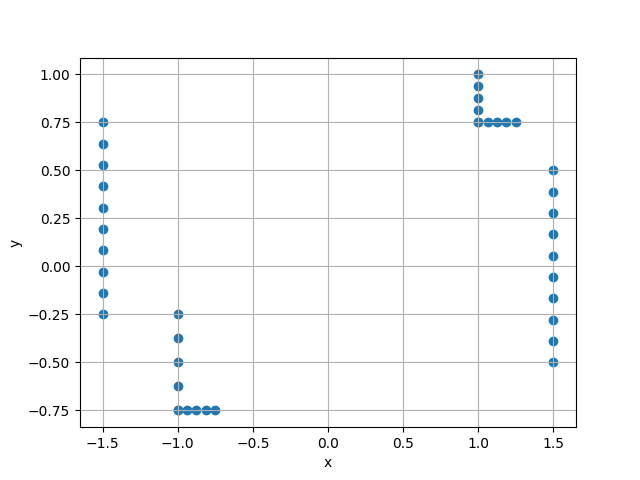

In [9]:
fig1 = plt.figure()
ax1 = fig1.gca()
plot_map_points(ax1, test_points)
format_axes(ax1)

In [10]:
def rotation_2d(angle_radians):
    cos = np.cos(angle_radians)
    sin = np.sin(angle_radians)
    return np.array([[cos, -sin], [sin, cos]])

def rotation_2d_homogeneous(angle_radians):
    cos = np.cos(angle_radians)
    sin = np.sin(angle_radians)
    z = np.zeros_like(angle_radians)
    o = np.ones_like(angle_radians)
    return np.array([[cos, -sin, z], [sin, cos, z], [z, z, o]])

In [11]:
def rotate_translate_homogeneous(angle_radians, translate):
    transform = rotation_2d_homogeneous(angle_radians)
    transform[:2, 2] = translate
    return transform

In [12]:
def to_homogeneous(vector):
    return np.concatenate([vector, np.ones((len(vector), 1))], axis=-1)

In [13]:
class Robot:
    def __init__(self, initial_state):

        self.initial_state = initial_state
        self.state = initial_state

    def step(self, dt, command):
        """Command: [v,w]"""

        theta = self.state[2,0]
        align_velocity = np.array([[np.cos(theta), 0.0,], [np.sin(theta), 0.0], [0.0, 1.0]])
        self.state = self.state + ((align_velocity @ command) * dt)
    
    def get_state(self):
        return self.state


In [32]:
def plot_robot_state(ax, state):
    ax.scatter([state[0]], [state[1]])
    ax.quiver([state[0]], [state[1]], [np.cos(state[2])], [np.sin(state[2])])

In [33]:
commands = [
    (0, np.array([[0.0,0.0]]).T),
    (1, np.array([[1.0,0.0]]).T),
    (1.0, np.array([[0.0,math.pi/2]]).T),
    (0.1, np.array([[2.5,0.0]]).T),
    (0.5, np.array([[0.0,math.pi/2]]).T),
    (1, np.array([[2.0,0.0]]).T),
]

In [34]:
robot = Robot(np.array([[0.0,0.0,0.0]]).T)

In [35]:
max_time = 3
dt = 0.1

robot_states = []
observations = []

current_time = 0
robot_states.append(robot.get_state())

current_command = commands[0]
next_command_index = 1
last_command_time = 0

test_points_homogeneous = to_homogeneous(test_points)

previous_odom_global_pose = np.zeros((3,1))

while current_time <= max_time:
    # Simulate
    pre_step_state = robot.get_state()
    robot.step(dt, current_command[1])
    after_step_state = robot.get_state()

    robot_states.append(after_step_state)

    # Record observation

    # odometry = after_step_state - pre_step_state

    T_previous = rotate_translate_homogeneous(pre_step_state[2,0], pre_step_state[:2,0])
    T_current = rotate_translate_homogeneous(after_step_state[2,0], after_step_state[:2,0])

    base = np.array([[0.0, 0.0, 1.0], [1.0,0.0, 1.0]])
    relative_base = base @ T_current.T @ np.linalg.inv(T_previous).T

    relative_base_heading = relative_base[1] - relative_base[0]
    relative_base_angle = np.arctan2(relative_base_heading[1], relative_base_heading[0])

    odometry = np.expand_dims(np.concatenate([relative_base[0, :-1].T, [relative_base_angle]], axis=0), -1)

    transform = rotate_translate_homogeneous(-after_step_state[2,0], -after_step_state[:2,0])
    transformed_test_points = test_points_homogeneous @ transform.T
    transformed_test_points = transformed_test_points / np.expand_dims(transformed_test_points[:, -1], -1)
    observations.append((odometry, transformed_test_points[:,:-1]))

    current_time += dt

    if (current_time - last_command_time) >= current_command[0]:
        if next_command_index < len(commands):
            current_command = commands[next_command_index]
            next_command_index += 1
            last_command_time = current_time



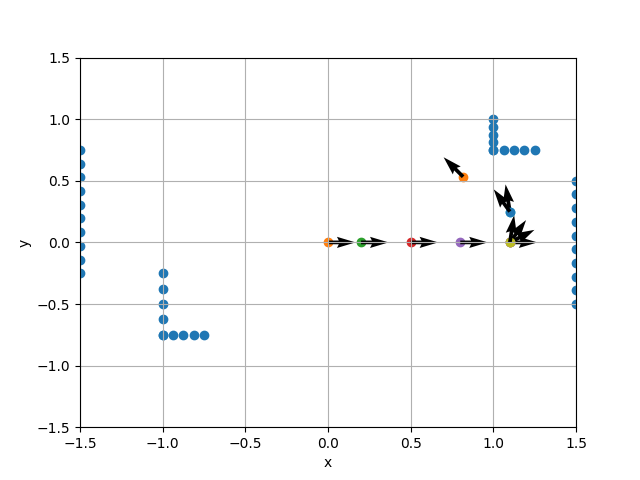

In [36]:
fig2 = plt.figure()
ax2 = fig2.gca()

plot_map_points(ax2, test_points)

plot_skip = 3

for state in robot_states[::plot_skip]:
    plot_robot_state(ax2, state)

format_axes(ax2, xlim=[-1.5, 1.5], ylim=[-1.5, 1.5])

(40, 2)
(40, 2)
(40, 2)
(40, 2)


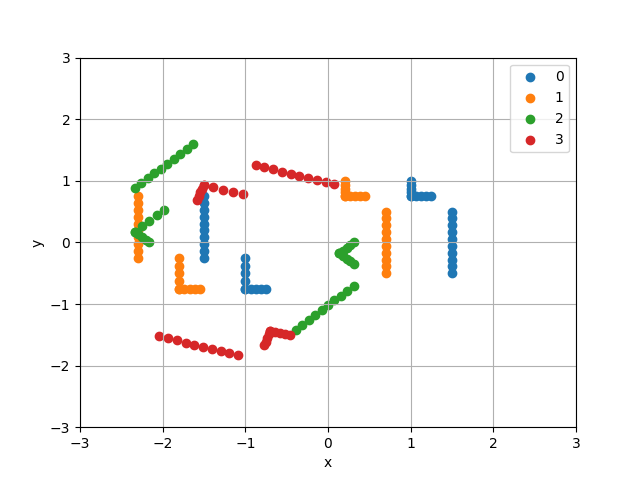

In [37]:
fig3 = plt.figure()
ax3 = fig3.gca()

plot_skip = 8

for i, (odometry, points) in enumerate(observations[::plot_skip]):
    print(points.shape)
    plot_map_points(ax3, points, label=f'{i}')

format_axes(ax3, xlim=[-3, 3], ylim=[-3,3])
ax3.legend()

Final Pose [Odom]: [[ 1.75000000e+00]
 [-3.05311332e-16]
 [ 2.35619449e+00]]
Final Pose [Act]: [[0.81715729]
 [0.53284271]
 [2.35619449]]


/tmp/ipykernel_1110509/2053024925.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax4.legend()


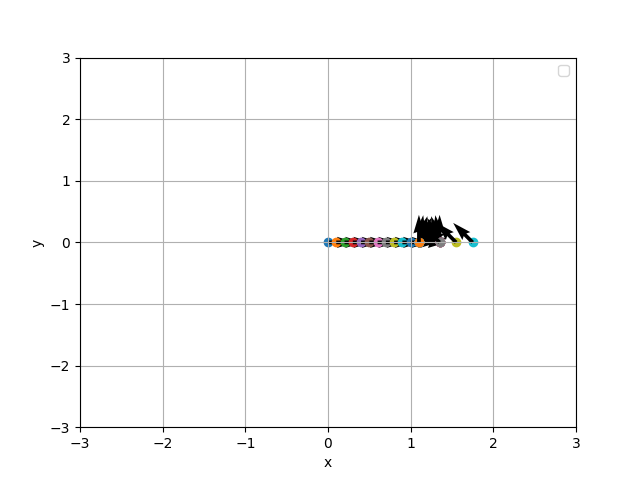

In [38]:
fig4 = plt.figure()
ax4 = fig4.gca()

plot_skip = 1

current_pose = np.array([[0.0, 0.0, 0.0]]).T

for i, (odometry, points) in enumerate(observations[::plot_skip]):
    current_pose += odometry
    plot_robot_state(ax4, current_pose)

format_axes(ax4, xlim=[-3, 3], ylim=[-3,3])
ax4.legend()

print(f'Final Pose [Odom]: {current_pose}')
print(f'Final Pose [Act]: {robot.get_state()}')

In [39]:
def corrupt_odometry(odometry, odometry_sigma):
    noise = np.random.normal(scale=odometry_sigma)   
    return odometry + noise 

In [40]:
def corrupt_scan(scan_points, scan_sigma):
    noise = np.random.normal(scale=scan_sigma, size=(scan_points.shape))   
    return scan_points + noise 

(40, 2)
(40, 2)
(40, 2)
(40, 2)


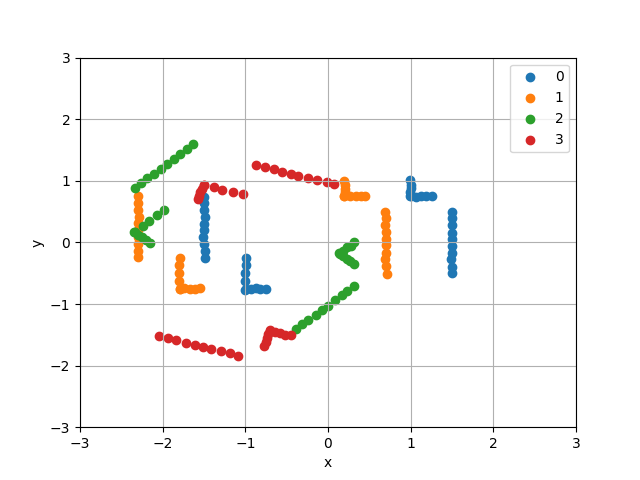

In [41]:
fig4 = plt.figure()
ax4 = fig4.gca()

plot_skip = 8

for i, (odometry, points) in enumerate(observations[::plot_skip]):
    print(points.shape)
    plot_map_points(ax4, corrupt_scan(points, np.array([[0.005, 0.005]])), label=f'{i}')

format_axes(ax4, xlim=[-3, 3], ylim=[-3,3])
ax4.legend()

In [42]:
perfect_graph = gtsam.NonlinearFactorGraph()

In [43]:
pose_symbol = lambda index: gtsam.symbol('p', index)

In [44]:
odometry_noise_np = np.array([0.01, 0.01, 5*math.pi/180])
odometry_noise = gtsam.noiseModel.Diagonal.Sigmas(odometry_noise_np)
landmark_noise_np = np.array([0.015, 0.015])
landmark_noise = gtsam.noiseModel.Diagonal.Sigmas(landmark_noise_np)

In [45]:
prior_noise = gtsam.noiseModel.Diagonal.Sigmas([0.1, 0.1, 5 * math.pi/180])
perfect_graph.push_back(gtsam.PriorFactorPose2(pose_symbol(0), gtsam.Pose2(0, 0, 0), prior_noise))

In [46]:
initial_estimate = gtsam.Values()
initial_estimate.insert(pose_symbol(0), gtsam.Pose2(0.0, 0.0, 0.0))

In [47]:
parameters = gtsam.ISAM2Params()
parameters.setRelinearizeThreshold(0.1)
parameters.relinearizeSkip = 1
isam = gtsam.ISAM2(parameters)

In [51]:
data_skip = 1

current_estimate = initial_estimate

for i, (odometry, scans) in enumerate(observations[::data_skip]):

    odom_pose = gtsam.Pose2(odometry[0,0], odometry[1,0], odometry[2,0])
    
    perfect_graph.push_back(
        gtsam.BetweenFactorPose2(
            pose_symbol(i), pose_symbol(i+1), odom_pose, odometry_noise
        )
    )

    computed_estimate = current_estimate.atPose2(pose_symbol(i)).compose(odom_pose)

    initial_estimate.insert(pose_symbol(i+1), computed_estimate)

    isam.update(perfect_graph, initial_estimate)
    current_estimate = isam.calculateEstimate()

    initial_estimate.clear()


In [52]:
marginals = gtsam.Marginals(perfect_graph, current_estimate)

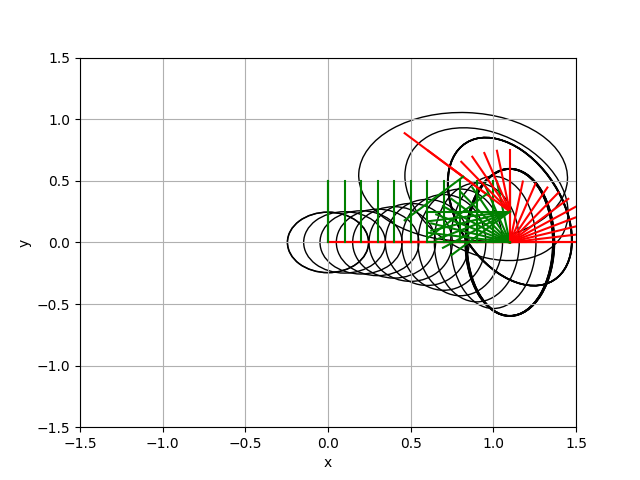

In [67]:
import gtsam.utils.plot

fig5 = plt.figure()
ax5 = fig5.gca()

i = 0
while current_estimate.exists(pose_symbol(i)):
    gtsam.utils.plot.plot_pose2_on_axes(ax5, current_estimate.atPose2(pose_symbol(i)), 0.5, marginals.marginalCovariance(pose_symbol(i)))
    i += 1

format_axes(ax5, xlim=[-1.5, 1.5], ylim=[-1.5, 1.5])

In [33]:
current_estimate.atPose2(pose_symbol(i-1))

(-0.141421, 0.141421, 1.59556e-16)

In [34]:
robot.get_state()

array([[0.81715729],
       [0.53284271],
       [2.35619449]])